In [2]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import proj3d

import pandas as pd
import scipy as sp
import scipy.integrate
from time import time
# VCSEL Parameters
a = linewidth_enhancement_factor  = 1 # alpha
g_p = linear_birefringence_rate = 20 # rad/ns, gamma_p
g_s = spin_relaxation_rate = 10 # 1/ns, gamma_s #frequency term
g_a = gain_anisotropy = 0 # 1/ns, gamma_a # frequency term
g = electron_lifetime_frequency = 1 # gamma, 1/ns, 1/tau_n
k = half_photon_lifetime_frequency = 125 # kappa = photon_lifetime/2

# Plot the surface.
color_rcp = "#2bfef0"
color_lcp = "#952bfe"

vcsel_parameters = {
    "a": a,
    "g_p": g_p,
    "g_s": g_s,
    "g_a": g_a,
    "g": g,
    "k": k
}
## VCSEL Variations
eta = 2
P = 0
O_x = 0
O_y = 0
O_z = 0

experiment_conditions = pd.DataFrame({
    "eta" : eta,
    "P" : P,
    "O_x" : O_x,
    "O_y" : O_y,
    "O_z" : O_z
}, index=[0])

experiment_conditions.values
initial_solution= np.ones(8) * 1

def spin_flip_differential_equations(t, initial_solution, vcsel_parameters, experiment_conditions):
    a = vcsel_parameters["a"]
    g_p = vcsel_parameters["g_p"]
    g_s = vcsel_parameters["g_s"]
    g_a = vcsel_parameters["g_a"]
    g = vcsel_parameters["g"]
    k= vcsel_parameters["k"]
    
    # Decompose experiment conditions
    eta = experiment_conditions["eta"]
    P = experiment_conditions["P"]
    O_x = experiment_conditions["O_x"]
    O_y = experiment_conditions["O_y"]
    O_z = experiment_conditions["O_z"]
    # Decompose solution array
    E_pr = initial_solution[0]
    E_mr = initial_solution[1]
    E_pi = initial_solution[2]
    E_mi = initial_solution[3]
    N = initial_solution[4]
    m_x = initial_solution[5]
    m_y = initial_solution[6]
    m_z = initial_solution[7]
    
    
    # Define resulting parameters
    I_p = (E_pr ** 2 + E_pi ** 2) 
    I_m = (E_mr ** 2 + E_mi ** 2)
    eta_substract = P * eta
    eta_add = eta
    
    # Array of solutions
    dS = np.zeros_like(initial_solution) # Differntial system equations
    
    ## Differential equation systems
    # Emission EM Energy Componentns
    dE_pr = k * (N + m_z - 1) * (E_pr - a * E_pi) - g_a * E_pr + g_p * E_mi - O_z * E_pi
    dE_mr = k * (N - m_z - 1) * (E_mr - a * E_mi) - g_a * E_mr + g_p * E_pi + O_z * E_mi
    dE_pi = k * (N + m_z - 1) * (E_pi + a * E_pr) - g_a * E_pi - g_p * E_mr + O_z * E_pr
    dE_mi = k * (N - m_z - 1) * (E_mi + a * E_mr) - g_a * E_mi - g_p * E_pr - O_z * E_mr
    # Electron recombination rate
    dN = g * (eta_add - (1 + I_p + I_m) * N - (I_p - I_m) * m_z)
    # Normalized electron spin magnetization
    dm_x = - (g_s + g * (I_p + I_m)) * m_x + O_y * m_z - O_z * m_y
    dm_y = - (g_s + g * (I_p + I_m)) * m_y + O_z * m_x - O_x * m_z
    dm_z = g * (eta_substract) - (g_s +
             g * (I_p + I_m)) * m_z - g * (I_p - I_m) * N + O_x * m_y - O_y * m_x
    
    # Differential compilation
    dS = np.array([dE_pr, dE_mr, dE_pi, dE_mi, dN, dm_x, dm_y, dm_z])
    return dS

# Stored variable usage
dS_columns = np.array(["dE_pr", "dE_mr", "dE_pi", "dE_mi", "dN", "dm_x", "dm_y", "dm_z"])
results_columns = dS_columns

In [3]:
def further_results(solution = np.zeros(9)):
    # Total Right Circular Emission Radiant Energy and Intensity 
    E_p = np.sqrt(solution[0] ** 2 + solution[2] ** 2)
    E_m = np.sqrt(solution[1] ** 2 + solution[3] ** 2)
    N = solution[4]
    I_p = E_p ** 2
    I_m = E_m ** 2
    # Total emission intensity
    I = (I_p + I_m)/2
    
    # Orthogonal Linear Components
    E_x = (E_p + E_m) / np.sqrt(2)
    E_y = -(E_p - E_m) / np.sqrt(2)
    I_x = E_x ** 2
    I_y = E_y ** 2
    
    # Total emission elipticity
    I_difference = (I_p - I_m)
    e =  I_difference / (I_p + I_m)
    
    return np.array([E_p, E_m, I_p, I_m, I_difference, I, E_x, E_y, I_x, I_y, e, N])

further_results_columns = np.array(["E_p", "E_m", "I_p", "I_m", "I_difference", "I", "E_x", "E_y,", "I_x", "I_y", "e", "N"])
results_columns = np.append(results_columns, further_results_columns)

In [4]:
def plot_results(simulation_time, solution, detailed_solution):
    #  +, - Components
    plt.figure()
    plt.plot(simulation_time, solution[0], label="E_pr")
    plt.plot(simulation_time, solution[1], label="E_mr")
    plt.legend()
    
    # I_n, I_p
    plt.figure()
    plt.plot(simulation_time, detailed_solution[2], label="I_p")
    plt.plot(simulation_time, detailed_solution[3], label="I_n")
    plt.ylim((0,1))
    plt.legend()
    
    # X-Y Components
    plt.figure()
    plt.plot(simulation_time, detailed_solution[6], label="E_x")
    plt.plot(simulation_time, detailed_solution[7], label="E_y")
    plt.legend()
    
    # Elipticity
    plt.figure()
    plt.plot(simulation_time, detailed_solution[8], label= "Elipticity Eta")
    plt.legend()

In [5]:
# def travagnin_spin_flip_differential_equations(t, 
#                                       initial_solution=np.zeros(8), 
#                                       vcsel_parameters=np.zeros(6),
#                                       experiment_conditions=np.zeros(5)
#                                     ):

#     dI = 2 * I (k * (N - 1) - g_a * np.cos(2 * W) * np.cos(2 * X) + k * m_z * np.sin(2 * X))
#     dTheta = -k * a * (N - 1) - g_a * np.sin(2 * W) * np.tan(2 * X) + g_p * np.cos(2 * W) / np.cos(2 * X)
#     dX = k * m_z * np.cos(2 * X) + g_a * np.cos(2 * W) * np.sin(2 * X) + g_p * np.cos(2 * W) * np.tan(2 * X)
#     dW = -O_z - k * a * m_z + g_a * np.sin(2 * W) / np.cos(2 * X) - g_p * np.cos(2 * W) * np.tan(2 * X)
#     dN = g * (eta - (1 + 2 * I) * N -  2 * I * np.sin(2 * X) * m_z) 
#     dm_z = g * P * eta - (g_s + 2 * g * I) * m_z - 2 * g * I * np.sin(2 * X) * N
    
#     # Differential compilation
#     dS = np.array([dE_pr, dE_mr, dE_pi, dE_mi, dN, dm_x, dm_y, dm_z])
#     return dS

In [6]:
def vcsel_experimental_modelling(vcsel_parameters,
                                 experiment_conditions, initial_solution= np.ones(8) * 1):
    
    # Set up simulation time
    min_simulation_time = 0
    max_simulation_time = 35
    simultion_time_steps= 5
    simulation_time = np.arange(min_simulation_time, max_simulation_time, simultion_time_steps)
    integration_interval = [min_simulation_time, max_simulation_time]

    
    # Integration solver
    sim_results = sp.integrate.solve_ivp(spin_flip_differential_equations,
                                    integration_interval,
                                    initial_solution,
                                    method='Radau',
                                    t_eval=simulation_time,
                                    dense_output=True,
                                    args=(vcsel_parameters,
                                          experiment_conditions))
    
    
    # Selected solution range
    solution = sim_results.sol(simulation_time)
    detailed_solution = further_results(solution)
    simulation_data = np.concatenate((solution, detailed_solution), 0)
    
    
    # Get derived parameters
    experiment_conditions_dataframe = pd.DataFrame(experiment_conditions,
                                                   index=[0])
    vcsel_parameters_dataframe = pd.DataFrame(vcsel_parameters,
                                                   index=[0])
    repeated_experiment_conditions = pd.concat(
        [experiment_conditions_dataframe]*simulation_time.size, ignore_index=True)
    repeated_vcsel_parameters = pd.concat(
        [vcsel_parameters_dataframe]*simulation_time.size, ignore_index=True)
    
    # Simulation dataframe
    simulation_dataframe = pd.DataFrame(simulation_data.T,
                                        columns = results_columns)
    simulation_dataframe["simulation_time"] = simulation_time
    
    for experimental_parameter in repeated_experiment_conditions.keys():
        simulation_dataframe[
            experimental_parameter] =  repeated_experiment_conditions[
                                            experimental_parameter]
        
    for vcsel_parameter in repeated_vcsel_parameters.keys():
        simulation_dataframe[
            vcsel_parameter] =  repeated_vcsel_parameters[
                                    vcsel_parameter]
        
    return simulation_dataframe

In [7]:
## VCSEL Variations
eta = 2
P = 0
O_x = 0
O_y = 0
O_z = 0

experiment_conditions = pd.DataFrame({
    "eta" : eta,
    "P" : P,
    "O_x" : O_x,
    "O_y" : O_y,
    "O_z" : O_z
}, index=[0])



In [32]:
##################################################################################################
## Magnetic Field Variations
a = linewidth_enhancement_factor  = 5 # alpha
g_p = linear_birefringence_rate = 34.5 # rad/ns, gamma_p
g_s = spin_relaxation_rate = 105 # 1/ns, gamma_s #frequency term
g_a = gain_anisotropy = 0 # 1/ns, gamma_a # frequency term
g = electron_lifetime_frequency = 1 # gamma, 1/ns, 1/tau_n
k = half_photon_lifetime_frequency = 250 # kappa = photon_lifetime/2
saved_O_z_variations_DataFrame = pd.read_csv("simulation_results/magnetic_field_data2.csv")
stable_saved_O_z_variations_DataFrame = saved_O_z_variations_DataFrame[saved_O_z_variations_DataFrame.simulation_time > 20]

initial_time = int(time())

# Varing VCSEL parameters
magneto_birefringence_variations_dataframe = pd.DataFrame()
for O_z_i in np.linspace(0, 3, 50):
    # print("g_p_i: " + str(g_p_i))
    # print("time: " + str(int(time()-initial_time)))
    vcsel_parameters = {
        "a": a,
        "g_p": g_p,
        "g_s": g_s,
        "g_a": g_a,
        "g": g,
        "k": k
    }
    experiment_conditions = {
        "eta" : 2,
        "P" : 0,
        "O_x" : 0,
        "O_y" : 0,
        "O_z" : O_z_i
    }

    iteration_dataframe = vcsel_experimental_modelling(vcsel_parameters, experiment_conditions)
    magneto_birefringence_variations_dataframe = magneto_birefringence_variations_dataframe.append(iteration_dataframe, ignore_index=True)

magneto_birefringence_variations_dataframe.to_csv(
    "simulation_results/magneto_birefringence_variations_" 
     + str(int(time())) 
     + ".csv")
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
colors =['red', 'lime', 'purple', 'gold']
weak_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[0]
strong_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[10]
start_time = 30
end_time = 35



(-1.1, 1.1)

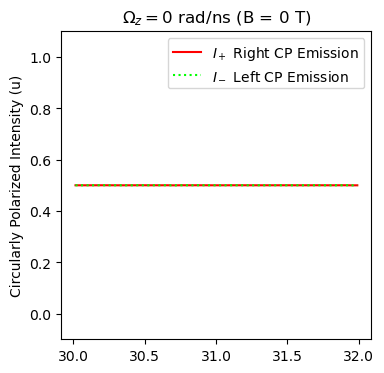

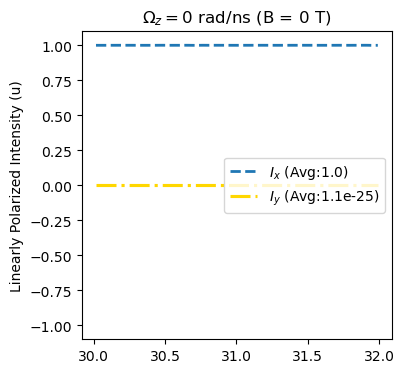

In [67]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_title(r'$\Omega_z = 0$ rad/ns (B = 0 T)')
ax.plot(weak_field_model_data.simulation_time,
              weak_field_model_data.I_p,
              color=colors[0],
              ls=linestyles[0],
              label=r'$I_+$ Right CP Emission')

ax.plot(weak_field_model_data.simulation_time,
              weak_field_model_data.I_m,
              color=colors[1],
              ls=linestyles[1],
              label=r'$I_-$ Left CP Emission')

ax.legend()
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Circularly Polarized Intensity (u)")

fig = plt.figure(figsize=(4,4))

ax1 = fig.add_subplot(111)
ax1.set_title(r'$\Omega_z = 0$ rad/ns (B = 0 T)')
ax1.plot(weak_field_model_data.simulation_time,
              weak_field_model_data.I_x,
              ls=linestyles[2],
              linewidth=2,
              label=r'$I_x$ (Avg:' + str("{:.2}".format(np.mean(weak_field_model_data.I_x))) + ')'
             )

ax1.plot(weak_field_model_data.simulation_time,
              weak_field_model_data.I_y,
              color=colors[3],
              ls=linestyles[3],
              linewidth=2.25,
              label=r'$I_y$ (Avg:' + str("{:.2}".format(np.mean(weak_field_model_data.I_y))) + ')'
             )

ax1.legend(loc='right')

ax1.set_ylabel("Linearly Polarized Intensity (u)")

ax1.set_ylim(-1.1, 1.1)

Text(0.5, 0, 'Simulation time (ns)')

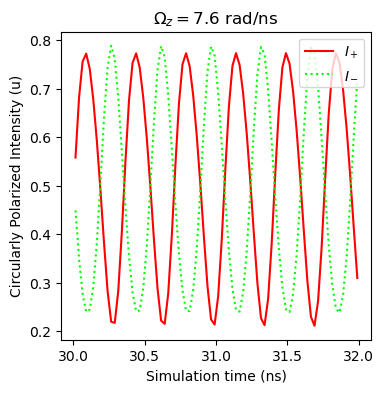

In [51]:
fig = plt.figure(figsize=(4,4))
ax2 = fig.add_subplot(111)

ax2.set_title(r'$\Omega_z = 7.6$ rad/ns ')
ax2.set_ylabel("Circularly Polarized Intensity (u)")

ax2.plot(strong_field_model_data.simulation_time,
              strong_field_model_data.I_p,
              color=colors[0],
              ls=linestyles[0],
              label=r'$I_+$')

ax2.plot(strong_field_model_data.simulation_time,
              strong_field_model_data.I_m,
              color=colors[1],
              ls=linestyles[1],
              label=r'$I_-$')

ax2.legend(loc='upper right')
ax2.set_xlabel("Simulation time (ns)")



Text(0.5, 0, 'Simulation time (ns)')

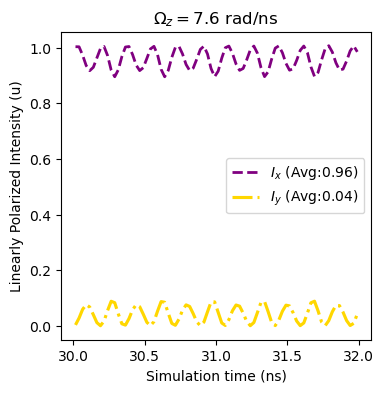

In [52]:
fig = plt.figure(figsize=(4,4))
ax3 = fig.add_subplot(111)
ax3.set_title(r'$\Omega_z = 7.6$ rad/ns ')
ax3.set_ylabel("Linearly Polarized Intensity (u)")

ax3.plot(strong_field_model_data.simulation_time,
              strong_field_model_data.I_x,
              color=colors[2],
              ls=linestyles[2],
              linewidth=2,
              label=r'$I_x$ (Avg:' + str("{:.2}".format(np.mean(strong_field_model_data.I_x))) + ')'
             )

ax3.plot(strong_field_model_data.simulation_time,
              strong_field_model_data.I_y,
              color=colors[3],
              ls=linestyles[3],
              linewidth=2.25,
              label=r'$I_y$ (Avg:' + str("{:.2}".format(np.mean(strong_field_model_data.I_y))) + ')'
             )

ax3.legend(loc='center right')
ax3.set_xlabel("Simulation time (ns)")

<ipython-input-66-29f8972557b5>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weak_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == weak_field_O_z]
<ipython-input-66-29f8972557b5>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slight_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == slight_field_O_z]
<ipython-input-66-29f8972557b5>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  threshold_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == threshold_field_O_z]
<ipython-input-66-29f8972557b5>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pre_metastable_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == pre_metastable_field_O_z]
<ipython-input-66-29f8972557b5>:23: UserWa

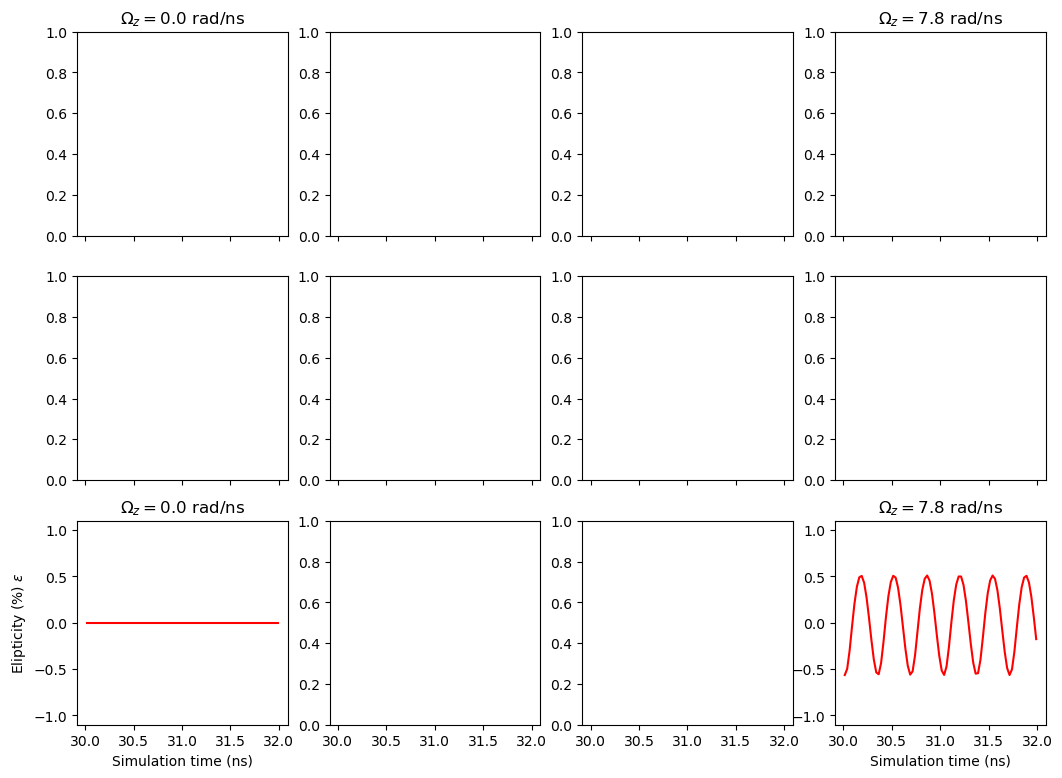

In [66]:
field_indices = [0, 48]

selected_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[0]
weak_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[0]
slight_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[12]
threshold_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[13]
pre_metastable_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[18]
metastable_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[21]
metastable_threshold_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[28]
medium_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[30]
strong_field_O_z = stable_saved_O_z_variations_DataFrame.O_z.unique()[48]

start_time = 30
end_time = 32

simulation_selection_model_data = stable_saved_O_z_variations_DataFrame[(stable_saved_O_z_variations_DataFrame.simulation_time > start_time) & 
                                                              (stable_saved_O_z_variations_DataFrame.simulation_time < end_time)]

weak_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == weak_field_O_z]
slight_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == slight_field_O_z]
threshold_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == threshold_field_O_z]
pre_metastable_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == pre_metastable_field_O_z]
metastable_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == metastable_field_O_z]
metastable_threshold_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == metastable_threshold_field_O_z]
medium_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == medium_field_O_z]
strong_field_model_data = simulation_selection_model_data[stable_saved_O_z_variations_DataFrame.O_z == strong_field_O_z]

plt.style.use('default')
fig_section_1, axs_1 = plt.subplots(3, 4, figsize=(12.5, 9), sharex=True)


def magnetobirefringence_column_subplots(axs, dataframe, magneto_birefringence_value, index, section=0):
    axs[section,index].set_title(r'$\Omega_z = $' + 
                           str("{:.1f}".format(magneto_birefringence_value)) + 
                           ' rad/ns')

#     axs[section,index].plot(dataframe.simulation_time,
#                   dataframe.I_p,
#                   color=colors[0],
#                   ls=linestyles[0],
#                   label=r'$I_+$')

#     axs[section,index].plot(dataframe.simulation_time,
#                   dataframe.I_m,
#                   color=colors[1],
#                   ls=linestyles[1],
#                   label=r'$I_-$')

#     axs[section,index].legend(loc='upper right')
#     axs[section,index].set_ylim(-0.1, 1.1)

#     axs[section+1,index].plot(dataframe.simulation_time,
#                               dataframe.I_x,
#                               color=colors[2],
#                               ls=linestyles[2],
#                               label=r'$I_x$ (Avg:' + str("{:.2f}".format(np.mean(dataframe.I_x))) + ')'
#                              )

#     axs[section+1,index].plot(dataframe.simulation_time,
#                               dataframe.I_y,
#                               color=colors[3],
#                               ls=linestyles[3],
#                               label=r'$I_y$ (Avg:' + str("{:.2}".format(np.mean(dataframe.I_y))) + ')'
#                              )
    
#     axs[section+1,index].legend(loc='center right')
#     axs[section+1,index].set_ylim(-0.1, 1.4)
    
    axs[section+2,index].plot(dataframe.simulation_time,
                  dataframe.e,
                  '-',
                  color="red",
                  label=r'$\eta$')
    
    axs[section+2,index].set_ylim(-1.1, 1.1)
    axs[section+2,index].set_xlabel("Simulation time (ns)")
    axs[section+2,index].set_title(r'$\Omega_z = $' + 
                           str("{:.1f}".format(magneto_birefringence_value)) + 
                           ' rad/ns')



axs_1[2,0].set_ylabel(r'Elipticity (%) $\epsilon$')

magnetobirefringence_column_subplots(axs_1, weak_field_model_data, weak_field_O_z, 0)
# magnetobirefringence_column_subplots(axs_1, slight_field_model_data, slight_field_O_z, 1)
# magnetobirefringence_column_subplots(axs_1, threshold_field_model_data, threshold_field_O_z, 2)
magnetobirefringence_column_subplots(axs_1, strong_field_model_data, strong_field_O_z, 3)


# for ax in fig_section_1.get_axes():
#     ax.label_outer()
    


# Section 2


# fig_section_2, axs_2 = plt.subplots(3, 4, figsize=(12.5,9), sharex=True)

# fig_section_2.suptitle("Magneto-circular birefringence $\Omega_z$ induced polarization switching (2)", fontsize=14)

# magnetobirefringence_column_subplots(axs_2, metastable_field_model_data, metastable_field_O_z, 0)
# magnetobirefringence_column_subplots(axs_2, metastable_threshold_field_model_data, metastable_threshold_field_O_z, 1)
# magnetobirefringence_column_subplots(axs_2, medium_field_model_data, medium_field_O_z, 2)
# magnetobirefringence_column_subplots(axs_2, strong_field_model_data, strong_field_O_z, 3)

# axs_2[0,0].legend()
# axs_2[0,0].set_ylim(-0.1,1.1)
# axs_2[0,0].set_ylabel("Circularly Polarized Intensity (%)")

# axs_2[1,0].legend(loc='center right')
# axs_2[1,0].set_ylabel("Linearly Polarized Intensity (%)")
# axs_2[1,0].set_xlabel("Simulation time (ns)")


# axs_2[2,0].set_ylabel(r'Elipticity (%) $\epsilon$')

# for ax in fig_section_2.get_axes():
#     ax.label_outer()
    
# plt.savefig("magneto_polarization_intensity_splitting_subplot_2_" 
#              + str(int(time())) 
#              + ".png", bbox_inches='tight')